In [9]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

def rossler(t, state, a, b, c):
    x, y, z = state  
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

a = 0.2
b = 0.2
c = 5.7
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 2510)

sol = solve_ivp(rossler, t_span, initial_state, args=(a, b, c), dense_output=True, t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

t = sol.t
z = sol.y

# CSVファイルにデータを保存
data = pd.DataFrame({'Time': t, 'x': z[0], 'y': z[1], 'z': z[2]})
data.to_csv('rossler_dataset.csv', index=False)

data_withouttime = pd.DataFrame({'x': z[0], 'y': z[1], 'z': z[2]})

# CSVファイルを読み込む
data_loaded = pd.read_csv('rossler_dataset.csv')

X = data_withouttime.values

X.shape


(25100, 3)

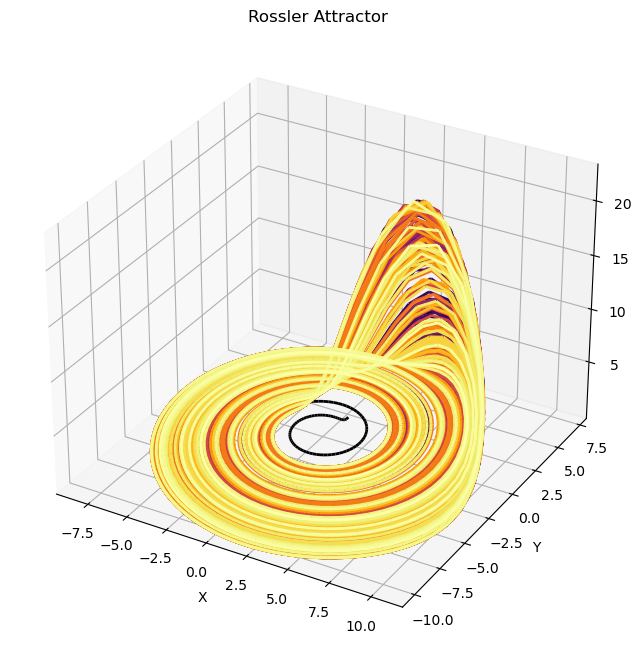

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np

def plot_rossler_3d_colored_efficient(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 時間に応じた色の変化を生成
    num_points = len(data)
    points = np.array([data['x'], data['y'], data['z']]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(data['Time'].min(), data['Time'].max())
    lc = Line3DCollection(segments, cmap='inferno', norm=norm)
    lc.set_array(data['Time'])
    lc.set_linewidth(2)
    ax.add_collection(lc)

    ax.set_xlim(data['x'].min(), data['x'].max())
    ax.set_ylim(data['y'].min(), data['y'].max())
    ax.set_zlim(data['z'].min(), data['z'].max())
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Rossler Attractor')
    plt.show()

# ここで `data_loaded` をレスラー方程式の解が含まれたデータフレームと仮定しています。
plot_rossler_3d_colored_efficient(data_loaded)


In [24]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [25]:
hyperopt_config = {
    "exp": f"hyperopt-rossler1.0", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [26]:
from reservoirpy.datasets import to_forecasting

train_len = 3000
test_len = 4000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [28]:
from reservoirpy.hyper import research

best = research(objective, dataset, "hyperopt-rossler1.0.config.json", "./hyperopt-rossler1.0")

100%|██████████| 200/200 [06:18<00:00,  1.89s/trial, best loss: 4.915409741433298e-06]


In [22]:
best

({'N': 0,
  'iss': 0.15716834911966804,
  'lr': 0.8156304946175557,
  'ridge': 4.290374941230941e-08,
  'seed': 0,
  'sr': 1.0385323042151453},
 <hyperopt.base.Trials at 0x28f203ee0>)